# Model Confidence Sets for Contextual Bandits: A Synthetic Study

## Abstract
We study the performance of classical contextual bandit algorithms, including 
$\epsilon$-greedy, LinUCB, and Thompson Sampling, in a synthetic Bernoulli-click 
environment. Each arm is associated with a latent linear parameter, and rewards 
follow a logistic model with Gaussian context vectors. To enable rigorous 
comparisons across policies, we employ the Model Confidence Set (MCS) procedure, 
which identifies the Superior Set of Models under bootstrap-based statistical 
tests. Our experiments, conducted over repeated trials, show that while LinUCB 
and Thompson Sampling achieve lower pseudo-regret on average, MCS reveals that 
several algorithms are statistically indistinguishable in performance. These 
results demonstrate the value of combining bandit experimentation with robust 
statistical evaluation, and suggest directions for extending this framework to 
non-linear models and real-world datasets.

---

## 1. Introduction
- Contextual bandits: sequential decision-making with side information  
- Importance: applications in recommendation, online advertising, adaptive control  
- Challenge: comparing policies with statistical guarantees  
- Contribution: synthetic study + Model Confidence Set (MCS) evaluation

---

## 2. Problem Setup

- Context $x_t \in \mathbb{R}^d$, arms $a \in \{1,\dots,K\}$

- Logistic reward model:

$$
\Pr(r_t=1 \mid x_t, a)
  = \sigma(x_t^\top \theta_a), \qquad
\sigma(u) = \frac{1}{1+e^{-u}} .
$$

- Oracle action and pseudo-regret:

$$
a_t^\star = \arg\max_{a} \sigma(x_t^\top \theta_a), \qquad
\mathcal{R}_T = \sum_{t=1}^T \left[\sigma(x_t^\top \theta_{a_t^\star}) - \sigma(x_t^\top \theta_{a_t})\right].
$$



---

## 3. Algorithms
- **$\epsilon$-greedy**: random exploration vs. linear score exploitation  
- **LinUCB**: upper confidence bound using ridge regression estimates  
- **Linear Thompson Sampling**: posterior sampling with Gaussian approximation  

---

## 4. Experimental Design
- Parameters: $K=5$, $d=5$, horizon $T=2000$, repeats $R=100$  
- Reward: logistic model with Gaussian contexts and latent arm parameters  
- Metrics: cumulative reward, average reward, pseudo-regret  

---

## 5. Results
- Boxplots of cumulative reward across repeats  
- Tables: mean ± std of rewards and regrets  
- Regret curves (if tracked)  

---

## 6. Model Confidence Set (MCS) Analysis
- MCS tests null hypothesis: “all models equally good”  
- Iteratively removes significantly inferior policies  
- Reports the $(1-\alpha)$ *Superior Set of Models*  

---

## 7. Discussion
- Trade-off between exploration and exploitation  
- MCS reveals which models are statistically indistinguishable  
- Limitations: synthetic setup, linear reward, iid contexts  

---

## 8. Conclusion
- Synthetic benchmark + MCS gives statistically reliable comparisons  
- LinUCB/TS strong on average, but some models not significantly worse  
- Future work: non-linear policies, non-stationary settings, real-world data  

---
## 9. Cited
- Agrawal, Shipra, and Navin Goyal. “Thompson Sampling for Contextual Bandits with Linear Payoffs.” Proceedings of the 30th International Conference on Machine Learning (ICML), vol. 28, 2013, pp. 127–135. PMLR.
- Chapelle, Olivier, and Lihong Li. “An Empirical Evaluation of Thompson Sampling.” Advances in Neural Information Processing Systems (NeurIPS), vol. 24, 2011.
- Chu, Wei, Lihong Li, Lev Reyzin, and Robert E. Schapire. “Contextual Bandits with Linear Payoff Functions.” Proceedings of the 14th International Conference on Artificial Intelligence and Statistics (AISTATS), vol. 15, 2011, pp. 208–214.
- Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, Ian Osband, and Zheng Wen. “A Tutorial on Thompson Sampling.” Foundations and Trends in Machine Learning, vol. 11, nos. 1–2, 2018, pp. 1–96.
- Upper Confidence Bound, Wikipedia, Wikimedia Foundation, en.wikipedia.org/wiki/Upper_Confidence_Bound. Accessed 27 Sept. 2025.
- University of Washington. Lecture 10: Contextual Bandits. CSE 599i: Exploration and Exploitation, Winter 2018, courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture10/lecture10.pdf.
- Sutton, Richard S., and Andrew G. Barto. Reinforcement Learning: An Introduction. 2nd ed., in progress, MIT Press, 2018.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from arch.bootstrap import MCS

### Logistic link (sigmoid)

We use the standard logistic function to map scores to Bernoulli click probabilities:
$
\sigma(u) = \frac{1}{1+e^{-u}}.
$

When arm $a$ is played under context $x_t$, the success probability is
$
p_{t,a} = \sigma(x_t^\top \theta_a).
$


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Experiment configuration

- Number of arms: $K$  
- Context dimension: $d$  
- Horizon (rounds per run): $T$  
- Repeated runs for stability: $R$  

In code, we set typical values such as `K=5`, `d=5`, `T=2000`, `R=100`.  
We seed RNGs for reproducibility.


In [4]:
narms = 5 

d = 5              
steps = 2000
repeats = 100
np.random.seed(42) 

true_thetas = [np.random.normal(0, 1, d) for _ in range(narms)]

### Policy interface and updates

We follow a simple interface with two methods:
- `select_arm(x)`: choose an arm given context $x_t$
- `update(x, a, r)`: update internal statistics with observed $(x_t, a_t, r_t)$

Examples:

**$\epsilon$-greedy (linear score).** Maintain per-arm linear estimates $\hat\theta_a$. With prob. $\epsilon$ explore uniformly; otherwise exploit via $\arg\max_a x_t^\top \hat\theta_a$.

**LinUCB.** Maintain $A_a = \lambda I + X_a^\top X_a$, $b_a = X_a^\top y_a$, $\hat\theta_a=A_a^{-1}b_a$, and select
$
a_t=\arg\max_a \big(x_t^\top \hat\theta_a + \alpha \sqrt{x_t^\top A_a^{-1} x_t}\big).
$

**Linear Thompson Sampling.** Sample $\tilde\theta_a \sim \mathcal{N}(\hat\theta_a, A_a^{-1})$, then play $\arg\max_a x_t^\top \tilde\theta_a$.


In [5]:
class CAB_EpsGreedy:
    def __init__(self, narms, d, epsilon):
        self.narms = narms
        self.d = d
        self.epsilon = epsilon

        self.X = [np.zeros((0, d)) for _ in range(narms)]
        self.y = [np.array([]) for _ in range(narms)]
        self.theta = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.narms)
        preds = [np.dot(context, self.theta[a]) for a in range(self.narms)]
        return np.argmax(preds)

    def update(self, context, arm, reward):
        self.X[arm] = np.vstack([self.X[arm], context])
        self.y[arm] = np.append(self.y[arm], reward)

        X_arm = self.X[arm]
        y_arm = self.y[arm]
        if X_arm.shape[0] >= self.d:
            reg = 1e-4 * np.eye(self.d)
            XtX = X_arm.T @ X_arm + reg
            Xty = X_arm.T @ y_arm
            self.theta[arm] = np.linalg.solve(XtX, Xty)



class CAB_LinUCB:
    def __init__(self, narms, d, alpha):
        self.narms = narms
        self.d = d
        self.alpha = alpha

        self.A = [np.identity(d) for _ in range(narms)]
        self.b = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        p = np.zeros(self.narms)
        for a in range(self.narms):
            A_inv = np.linalg.inv(self.A[a])
            theta_a = A_inv @ self.b[a]
            p[a] = context @ theta_a + self.alpha * np.sqrt(context @ A_inv @ context)
        return np.argmax(p)

    def update(self, context, arm, reward):
        x = context.reshape(-1, 1)
        self.A[arm] += x @ x.T
        self.b[arm] += reward * context



class CAB_ThompsonSampling:
    def __init__(self, narms, d):
        self.narms = narms
        self.d = d
        self.X = [np.zeros((0, d)) for _ in range(narms)]
        self.y = [np.array([]) for _ in range(narms)]
        self.theta_samples = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        preds = []
        for a in range(self.narms):
            if self.X[a].shape[0] < self.d:
                preds.append(np.random.rand())
                continue
            XTX = self.X[a].T @ self.X[a] + 1e-4 * np.eye(self.d)
            XTy = self.X[a].T @ self.y[a]
            theta_mean = np.linalg.solve(XTX, XTy)
            cov = np.linalg.inv(XTX)
            theta_sample = np.random.multivariate_normal(theta_mean, cov)
            preds.append(np.dot(context, theta_sample))
        return np.argmax(preds)

    def update(self, context, arm, reward):
        self.X[arm] = np.vstack([self.X[arm], context])
        self.y[arm] = np.append(self.y[arm], reward)



### Simulation loop

For each round $t=1,\dots,T$:
1. Sample context $x_t \sim \mathcal{N}(0, I_d)$
2. Policy chooses arm $a_t = \text{select\_arm}(x_t)$
3. Generate reward $r_t \sim \mathrm{Bernoulli}(\sigma(x_t^\top \theta_{a_t}))$
4. Update policy with $(x_t, a_t, r_t)$


We record cumulative reward and (optionally) pseudo-regret:
$
\mathcal{R}_T = \sum_{t=1}^T \left[\sigma(x_t^\top \theta_{a_t^\star}) - \sigma(x_t^\top \theta_{a_t})\right], \quad
a_t^\star = \arg\max_a \sigma(x_t^\top \theta_a).
$


In [6]:
def run_experiment_cab(policy_class, true_thetas, steps, d, **kwargs):
    narms = len(true_thetas)
    bandit = policy_class(narms, d, **kwargs)
    rewards = np.zeros(steps)

    for t in range(steps):
        context = np.random.normal(0, 1, d)
        arm = bandit.select_arm(context)
        click_prob = sigmoid(np.dot(context, true_thetas[arm]))
        reward = np.random.binomial(1, click_prob)
        bandit.update(context, arm, reward)
        rewards[t] = reward

    return rewards


In [7]:
policy_configs = {
    "Eps=0.0": (CAB_EpsGreedy, {"epsilon": 0.0}),
    "Eps=0.1": (CAB_EpsGreedy, {"epsilon": 0.1}),
    "Eps=0.3": (CAB_EpsGreedy, {"epsilon": 0.3}),
    "Eps=0.5": (CAB_EpsGreedy, {"epsilon": 0.5}),
    "LinUCB": (CAB_LinUCB, {"alpha": 0.5}),
    "TS": (CAB_ThompsonSampling, {}),
}


cumulative_rewards = {}

for name, (policy_class, params) in policy_configs.items():
    reward_list = []
    for _ in range(repeats):
        rewards = run_experiment_cab(policy_class, true_thetas, steps, d, **params)
        total_reward = rewards.sum()
        reward_list.append(total_reward)
    cumulative_rewards[name] = reward_list


### Model Confidence Set (MCS)

Let $\ell_m$ be the loss for model/policy $m$ on each repeated run (e.g., negative cumulative reward).
Define pairwise loss differentials $d_{m,m'} = \ell_m - \ell_{m'}$. The MCS algorithm bootstraps
these differentials to test the null hypothesis “all models are equally good” and iteratively
removes significantly inferior models, yielding the $(1-\alpha)$ *Superior Set of Models*.


In [8]:
'''MCS'''
policy_names = list(cumulative_rewards.keys())
reward_matrix = []

for i in range(repeats):
    row = []
    for name in policy_names:
        row.append(cumulative_rewards[name][i])
    reward_matrix.append(row)

reward_matrix = np.array(reward_matrix)
loss_matrix = -reward_matrix


In [9]:
mcs = MCS(loss_matrix, size=0.05, reps=1000, block_size=1)
mcs.compute()

included_indices = mcs.included
included_policies = [policy_names[i] for i in included_indices]

print("MCS 95% policy set: ")
print(included_policies)


MCS 95% policy set: 
['LinUCB']


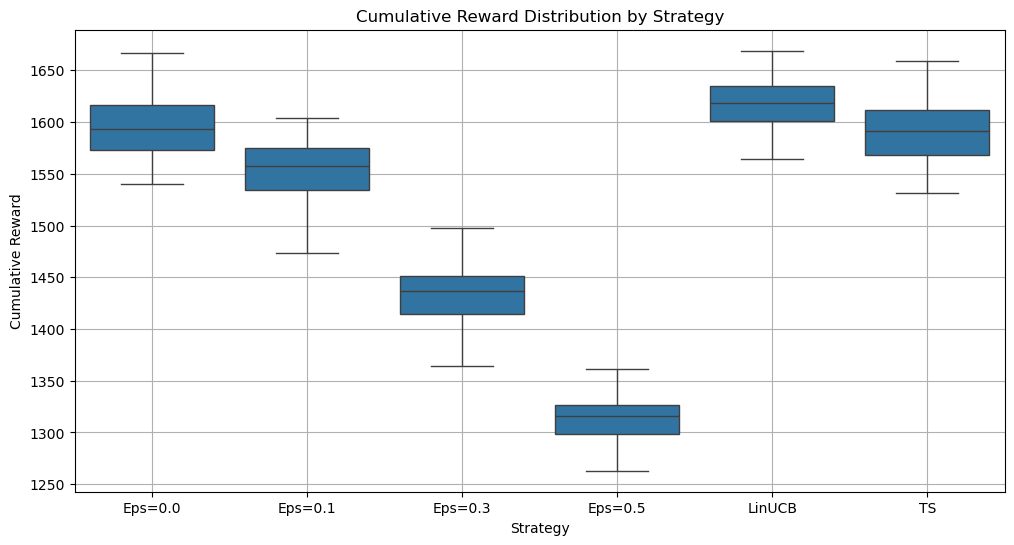

In [10]:
df = pd.DataFrame(cumulative_rewards)
df_melted = df.melt(var_name="Strategy", value_name="Cumulative Reward")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Strategy", y="Cumulative Reward")
plt.title("Cumulative Reward Distribution by Strategy")
plt.grid(True)
plt.show()



In [11]:
loss_matrix


array([[-1580., -1578., -1459., -1327., -1612., -1616.],
       [-1560., -1586., -1385., -1294., -1579., -1613.],
       [-1559., -1544., -1426., -1328., -1584., -1595.],
       [-1580., -1593., -1475., -1330., -1593., -1574.],
       [-1587., -1543., -1448., -1285., -1611., -1643.],
       [-1583., -1542., -1411., -1321., -1608., -1619.],
       [-1630., -1604., -1423., -1333., -1586., -1606.],
       [-1620., -1573., -1464., -1322., -1612., -1588.],
       [-1558., -1560., -1414., -1307., -1584., -1561.],
       [-1629., -1571., -1426., -1283., -1617., -1600.],
       [-1553., -1586., -1475., -1311., -1632., -1531.],
       [-1590., -1591., -1412., -1293., -1661., -1579.],
       [-1624., -1527., -1446., -1306., -1663., -1580.],
       [-1597., -1576., -1434., -1321., -1613., -1602.],
       [-1596., -1510., -1442., -1299., -1630., -1577.],
       [-1612., -1565., -1477., -1354., -1596., -1620.],
       [-1615., -1604., -1399., -1339., -1620., -1584.],
       [-1609., -1555., -1418.,